In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
# Define the CNN model architecture
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# Initialize global model
global_model = create_cnn_model()

In [5]:
# Initialize PSO parameters
w = 0.9  # Inertia weight
c1, c2 = 0.5, 0.5  # Cognitive and social coefficients

In [6]:
# Initialize agents
num_agents = 5
agents = [create_cnn_model() for _ in range(num_agents)]
personal_best_weights = [agent.get_weights() for agent in agents]
personal_best_loss = [float('inf')] * num_agents

In [7]:
# Initialize velocities
def initialize_velocity(models):
    velocity = []
    for model in models:
        model_velocity = []
        for weights in model.get_weights():
            model_velocity.append(np.zeros_like(weights))
        velocity.append(model_velocity)
    return velocity

velocity = initialize_velocity(agents)

In [8]:
# Split dataset among agents
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train, y_train = x_train[indices], y_train[indices]
splits = np.array_split(indices, num_agents)

In [9]:
# Training loop
epochs = 20
last_global_loss = float('inf')

In [10]:
# Lists to store metrics
all_train_accuracies = []
all_val_accuracies = []

for epoch in range(epochs):
    global_loss_improvement = False
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    for agent_index, agent in enumerate(agents):
        indices = splits[agent_index]
        x_agent_train, x_agent_val, y_agent_train, y_agent_val = train_test_split(x_train[indices], y_train[indices], test_size=0.1)

        history = agent.fit(x_agent_train, y_agent_train, validation_data=(x_agent_val, y_agent_val), epochs=1, batch_size=32, verbose=0)
        train_loss = history.history['loss'][0]
        train_accuracy = history.history['accuracy'][0]
        val_loss = history.history['val_loss'][0]
        val_accuracy = history.history['val_accuracy'][0]

        epoch_train_accuracies.append(train_accuracy)
        epoch_val_accuracies.append(val_accuracy)

        if val_loss < personal_best_loss[agent_index]:
            personal_best_loss[agent_index] = val_loss
            personal_best_weights[agent_index] = agent.get_weights()

        # Update velocity and weights using dynamic PSO
        for i, (current_weights, v) in enumerate(zip(agent.get_weights(), velocity[agent_index])):
            r1, r2 = np.random.random(), np.random.random()
            new_v = (w * v +
                     c1 * r1 * (personal_best_weights[agent_index][i] - current_weights) +
                     c2 * r2 * (global_model.get_weights()[i] - current_weights))
            current_weights += new_v
            velocity[agent_index][i] = new_v

        agent.set_weights([w + v for w, v in zip(agent.get_weights(), velocity[agent_index])])

        print(f"Agent {agent_index+1} - Epoch {epoch+1}: Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # Update global model to the best personal model
    best_agent_index = np.argmin(personal_best_loss)
    global_model.set_weights(personal_best_weights[best_agent_index])
    global_loss, global_accuracy = global_model.evaluate(x_test, y_test, verbose=0)

    # Adjust PSO coefficients based on performance improvement
    if global_loss < last_global_loss:
        global_loss_improvement = True
        last_global_loss = global_loss
    else:
        w *= 0.95  # Decrease inertia to dampen oscillations
        c1 *= 1.05  # Increase cognitive coefficient to encourage exploration
        c2 *= 1.05  # Increase social coefficient to spread influence

    avg_train_acc = np.mean(epoch_train_accuracies)
    avg_val_acc = np.mean(epoch_val_accuracies)
    all_train_accuracies.append(avg_train_acc)
    all_val_accuracies.append(avg_val_acc)

    print(f"Global Model - Epoch {epoch+1}: Test Loss: {global_loss:.4f}, Test Accuracy: {global_accuracy:.4f}")

Agent 1 - Epoch 1: Train Acc: 0.1569, Val Acc: 0.2200
Agent 2 - Epoch 1: Train Acc: 0.1076, Val Acc: 0.1010
Agent 3 - Epoch 1: Train Acc: 0.1787, Val Acc: 0.2640
Agent 4 - Epoch 1: Train Acc: 0.1474, Val Acc: 0.2420
Agent 5 - Epoch 1: Train Acc: 0.1762, Val Acc: 0.2500
Global Model - Epoch 1: Test Loss: 1.8960, Test Accuracy: 0.2446
Agent 1 - Epoch 2: Train Acc: 0.2182, Val Acc: 0.3070
Agent 2 - Epoch 2: Train Acc: 0.1130, Val Acc: 0.1030
Agent 3 - Epoch 2: Train Acc: 0.2766, Val Acc: 0.3410
Agent 4 - Epoch 2: Train Acc: 0.2183, Val Acc: 0.3030
Agent 5 - Epoch 2: Train Acc: 0.2469, Val Acc: 0.2850
Global Model - Epoch 2: Test Loss: 1.7300, Test Accuracy: 0.3609
Agent 1 - Epoch 3: Train Acc: 0.2607, Val Acc: 0.3410
Agent 2 - Epoch 3: Train Acc: 0.1840, Val Acc: 0.2450
Agent 3 - Epoch 3: Train Acc: 0.1940, Val Acc: 0.2630
Agent 4 - Epoch 3: Train Acc: 0.2396, Val Acc: 0.3400
Agent 5 - Epoch 3: Train Acc: 0.2911, Val Acc: 0.3800
Global Model - Epoch 3: Test Loss: 1.6615, Test Accuracy: 0.

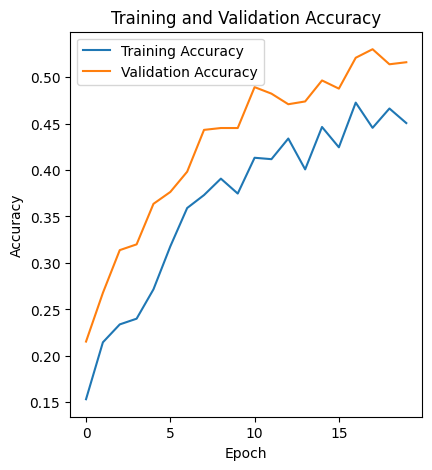

In [11]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(all_train_accuracies, label='Training Accuracy')
plt.plot(all_val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

313/313 [==============================] - 1s 5ms/step


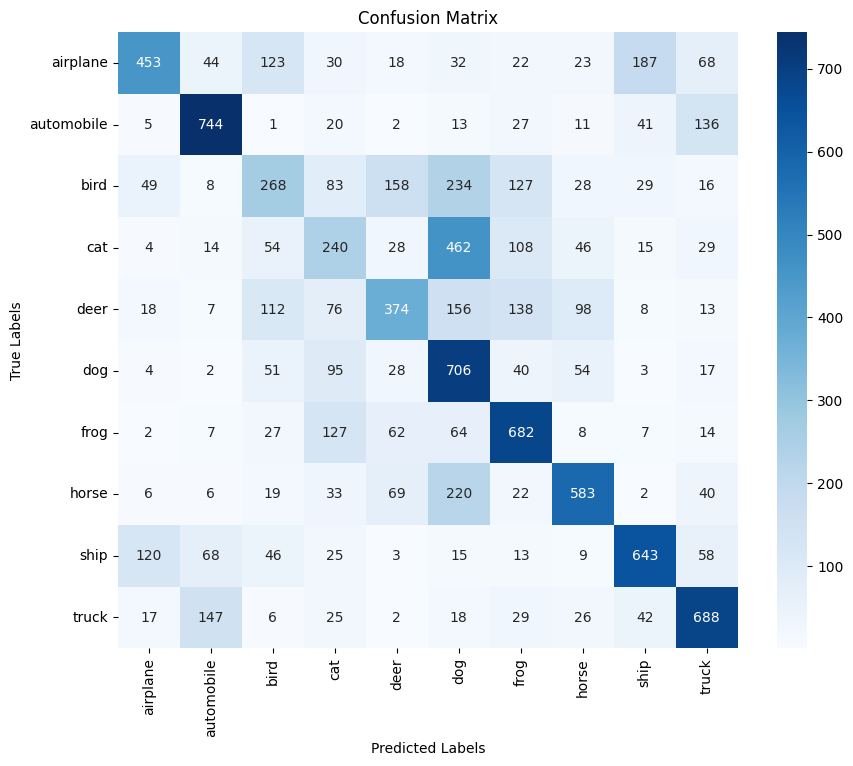

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the test dataset
predictions = global_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Define class names corresponding to CIFAR-10 labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


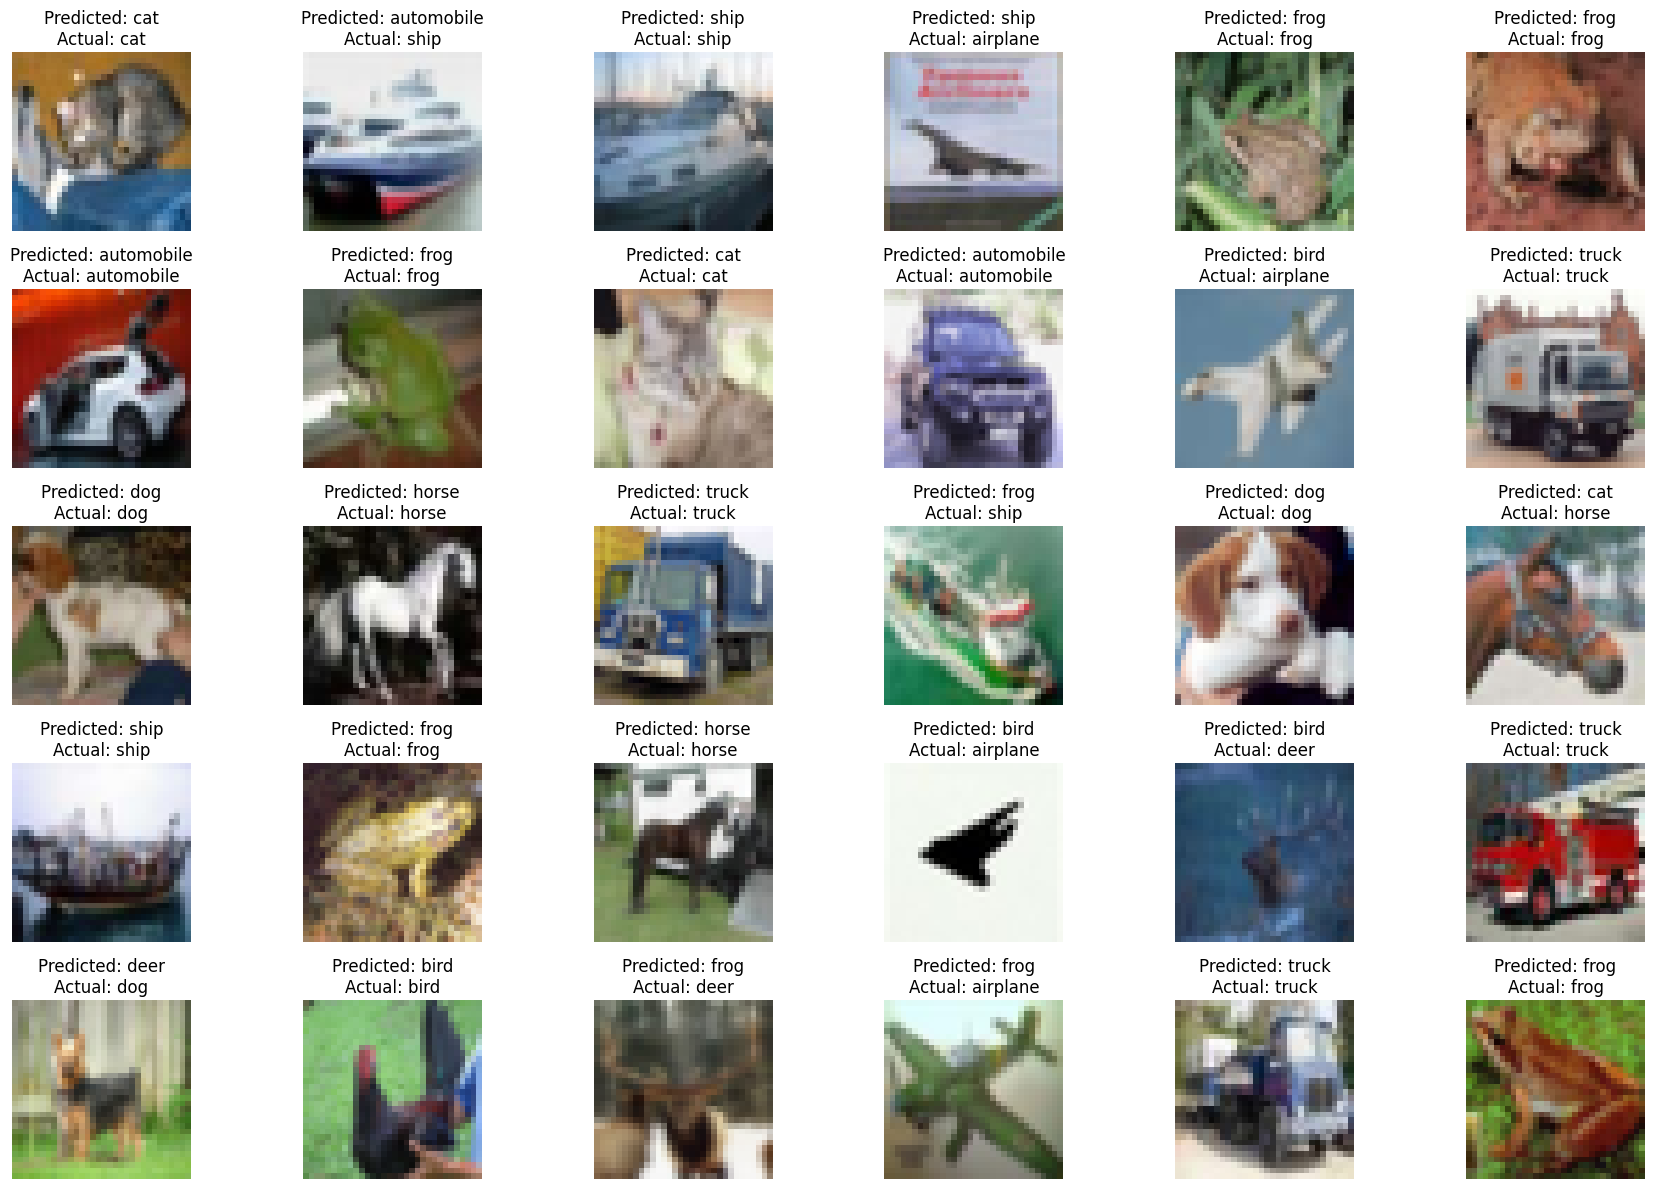

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(18, 12))  # Increase figure size for better visibility
for i in range(30):  # Display the first 30 images
    plt.subplot(5, 6, i + 1)  # Arranging plots in 5 rows and 6 columns
    plt.imshow(x_test[i])
    plt.title(f'Predicted: {class_names[predicted_classes[i]]}\nActual: {class_names[true_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
global_model.save('/content/drive/MyDrive/Colab Notebooks/h5/Level3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Load the model
model = load_model('/content/drive/MyDrive/Colab Notebooks/h5/trained_model_3.h5')  # Replace with the actual path to your model file

# Load the CIFAR-10 test dataset
(_, _), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
test_images = test_images.astype('float32') / 255.0

# Ensure that the test labels are in the correct format
test_labels = test_labels.squeeze()  # Remove unnecessary dimensions if present

# Convert labels to one-hot encoding
test_labels = to_categorical(test_labels, 10)  # Convert labels to one-hot, assuming 10 classes

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_images, test_labels, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 [==============================] - 1s 3ms/step - loss: 1.2684 - accuracy: 0.5381
Test Loss: 1.2683532238006592
Test Accuracy: 0.538100004196167
